In [1]:
#!pip install shap

In [2]:
#!pip install pandas-profiling

In [3]:
#!pip install seaborn

In [4]:
#Based on the following article
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [5]:
from pandas_profiling import ProfileReport

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [7]:
import shap
shap.initjs()

In [8]:
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Primary_Bank')
df = dataset.to_pandas_dataframe()

In [9]:
#profile = ProfileReport(df.sample(frac = 0.1))
#profile

In [10]:
df.columns

Index(['Customer_ID', 'Year', 'Month', 'Legal_Person', 'Gender',
       'Active_Customer', 'Segment', 'SubSegment', 'SubSubSegment',
       'Priority_Segment',
       ...
       'New_Primary_Bank_Flag', 'Minimum_ATM_Distance',
       'Minimum_Branch_Distance', 'Minimum_ATM_Distance_NWD',
       'Minimum_ATM_Distance_WD', 'Minimum_Branch_Distance_NWD',
       'Minimum_Branch_Distance_WD', 'Ex_Group_Sales_Flag',
       'RA_Account_Number_Count_1M', 'Total_Card_Purchases_Num_Sum_6M_Band'],
      dtype='object', length=302)

<AxesSubplot:title={'center':'New_Primary_Bank_Flag'}, ylabel='New_Primary_Bank_Flag'>

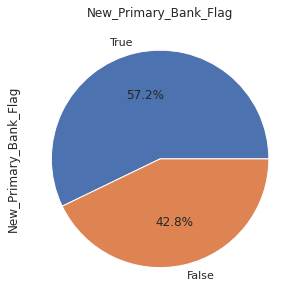

In [11]:
df['New_Primary_Bank_Flag'].value_counts().plot(kind = 'pie',y = 'New_Primary_Bank_Flag',figsize=(5, 5),title = 'New_Primary_Bank_Flag',autopct='%1.1f%%')


In [12]:
df = df.drop(columns = ['Customer_ID','Year','Month','Legal_Person', 'Active_Customer', 'Priority_Segment',	'Primary_Bank'])

In [13]:
def binF(x):
    if x is False:
        z = 0
    elif math.isnan(x):
        z = 0
    else:
        z =1
    return z

In [14]:
df['New_Primary_Bank_Flag'] = df['New_Primary_Bank_Flag'].apply(binF)

In [15]:
#dummy variables
for col in df.columns:       
       if df[col].dtypes=='object':
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])
    

In [16]:
for col in df.columns:       
       if df[col].dtypes=='datetime64[ns]':
            df = df.drop(columns = col)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns !='New_Primary_Bank_Flag'].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)



In [20]:
LR = LogisticRegression(penalty="l1", C=0.1,solver = 'liblinear')

In [21]:
LR.fit(x_train,y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [22]:
print(classification_report(y_train,  LR.predict(x_train)))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7453
           1       0.81      0.83      0.82      9796

    accuracy                           0.79     17249
   macro avg       0.79      0.79      0.79     17249
weighted avg       0.79      0.79      0.79     17249



In [23]:
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(LR.score(x_train, y_train)))

Accuracy of logistic regression classifier on train set: 0.7940


In [24]:
y_pred = LR.predict(x_test)

In [25]:
print(classification_report(y_test,  LR.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73      2399
           1       0.80      0.83      0.81      3351

    accuracy                           0.78      5750
   macro avg       0.77      0.77      0.77      5750
weighted avg       0.78      0.78      0.78      5750



In [26]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(LR.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.7798


In [27]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1718  681]
 [ 585 2766]]


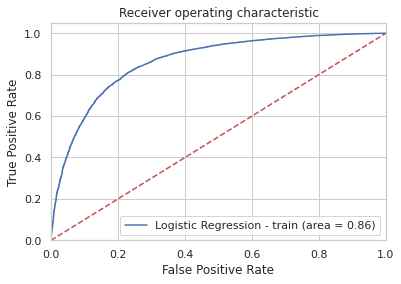

In [28]:
logit_roc_auc = roc_auc_score(y_train.to_numpy(), LR.predict(x_train))
fpr, tpr, thresholds = roc_curve(y_train.to_numpy(), LR.predict_proba(x_train)[:,1])
auc_train = roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='Logistic Regression - train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

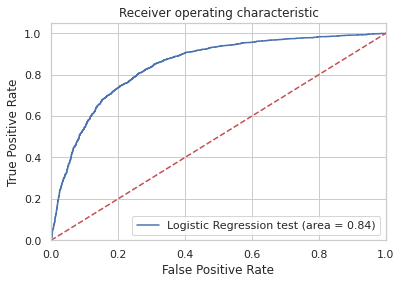

In [29]:
logit_roc_auc = roc_auc_score(y_test, LR.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, LR.predict_proba(x_test)[:,1])
auc_test = roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='Logistic Regression test (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")



In [30]:
explainer = shap.LinearExplainer(LR, x_train)
shap_values = explainer.shap_values(x_test)
x_test_array = x_test.to_numpy() # we need to pass a dense version for the plotting functions

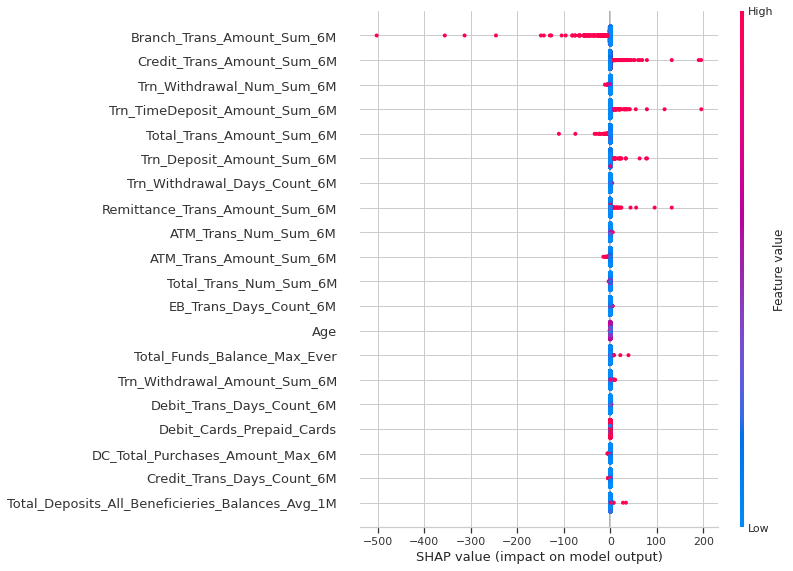

In [31]:
shap.summary_plot(shap_values, x_test_array,x_test.columns)
